# Bayesian UQ-SINDy

In [1]:
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(2)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps
import arviz as az

In [3]:
# set seed for reproducibility
np.random.seed(123)

## Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [4]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [5]:
# set some hyperparameters.
t_span = [0, 30]
t_eval = np.linspace(*t_span, 50)
y0 = np.array([10,5])

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, t_eval=t_eval)

In [6]:
# the noise level.
noise = 0.5

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

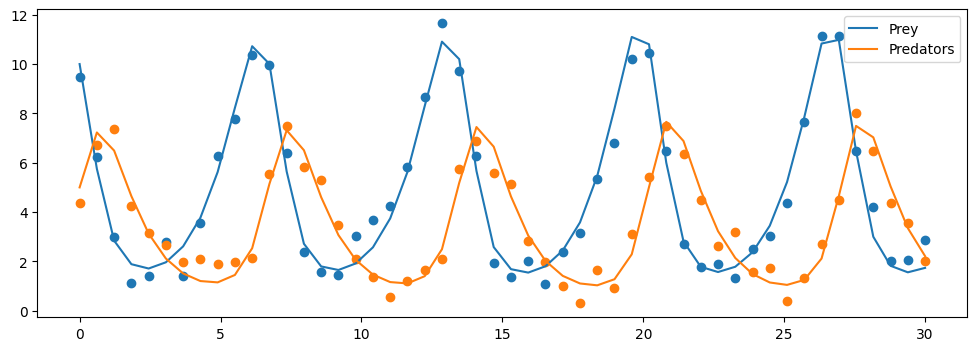

In [7]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

## Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [8]:
# set sampler hyperparameters
sampling_seed = 987

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 500
    num_samples = 2000
    num_chains = 2

### Use the approximate (fast) method.

In [9]:
# initialise the approximate Sparse Bayesian Regression optimizer.
approximate_optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                                          num_samples=num_samples,
                                          mcmc_kwargs={"seed": sampling_seed,
                                                       "num_chains": num_chains},
                                          exact=False)

# use the standard polynomial features.
feature_library = ps.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
approximate_sindy = ps.SINDy(approximate_optimizer, feature_library, feature_names=['P', 'Q'])
approximate_sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(exact=False, integrator_kwargs={},
                    mcmc_kwargs={'num_chains': 2, 'seed': 987},
                    num_samples=2000, num_warmup=500))

### Get MCMC diagnostics from the approximate method

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [10]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(approximate_optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.083,0.324,-0.391,0.755,0.015,0.011,771.0,559.0,1.01
"beta[0, 1]",0.972,0.159,0.663,1.260,0.006,0.004,883.0,754.0,1.00
"beta[0, 2]",-0.023,0.125,-0.289,0.209,0.005,0.004,1061.0,663.0,1.00
"beta[0, 3]",-0.033,0.017,-0.062,0.002,0.001,0.000,995.0,1032.0,1.00
"beta[0, 4]",-0.157,0.030,-0.212,-0.101,0.001,0.001,962.0,1914.0,1.00
"beta[0, 5]",-0.064,0.027,-0.115,-0.012,0.001,0.001,933.0,1010.0,1.01
"beta[1, 0]",-0.280,0.486,-1.473,0.271,0.024,0.018,591.0,455.0,1.01
"beta[1, 1]",-0.022,0.109,-0.260,0.178,0.004,0.003,861.0,579.0,1.00
"beta[1, 2]",-0.667,0.247,-1.065,-0.097,0.011,0.008,571.0,583.0,1.01
"beta[1, 3]",0.021,0.012,-0.000,0.044,0.000,0.000,1108.0,1275.0,1.00


[]

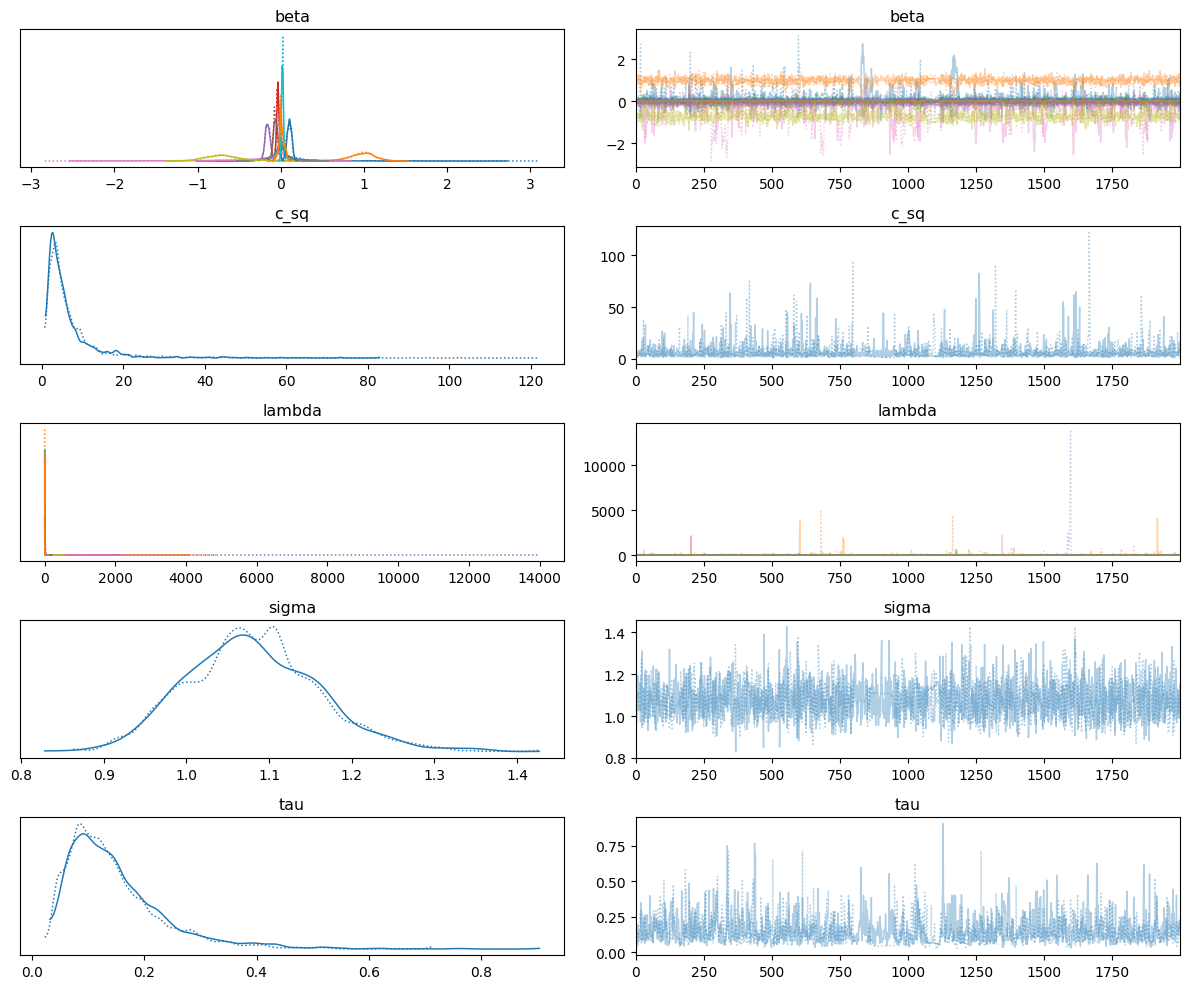

In [11]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()

In [12]:
posterior_mean = {key: value.mean(axis=0) for key, value in approximate_optimizer.mcmc_.get_samples().items()}

### Use the exact method.

In [13]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(num_warmup=num_warmup,
                              num_samples=num_samples,
                              mcmc_kwargs={"seed": sampling_seed,
                                           "num_chains": num_chains,
                                           "initial_values": posterior_mean},
                              integrator_kwargs={"dt": 0.5},
                              )

# use the standard polynomial features.
feature_library = ps.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR(integrator_kwargs={'dt': 0.5},
                    mcmc_kwargs={'initial_values': {'beta': Array([[ 0.08301367,  0.97238949, -0.0229219 , -0.03301487, -0.15675829,
        -0.06401244],
       [-0.27984928, -0.02176279, -0.66730898,  0.0214622 ,  0.10320613,
         0.00985338]], dtype=float64),
                                                    'c_sq': Array(6.75976994, dtype=float64),
                                                    'lambda': Array([[ 2.73088141, 25.90503495,  1.63351643,  1.7948182 , 15.26719818,
         1.53698334],
       [ 6.91284361,  1.23944222, 11.48347587,  0.74111183,  2.1466631 ,
         0.89273518]], dtype=float64),
                                                    'sigma': Array(1.08005973, dtype=float64),
                                                    'tau': Array(0.14805314, dtype=float64)},
                                 'num_chains': 2, 'seed': 987},
                    num_samples=2000, num_warmup=500))

In [14]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, t_eval=t_eval)

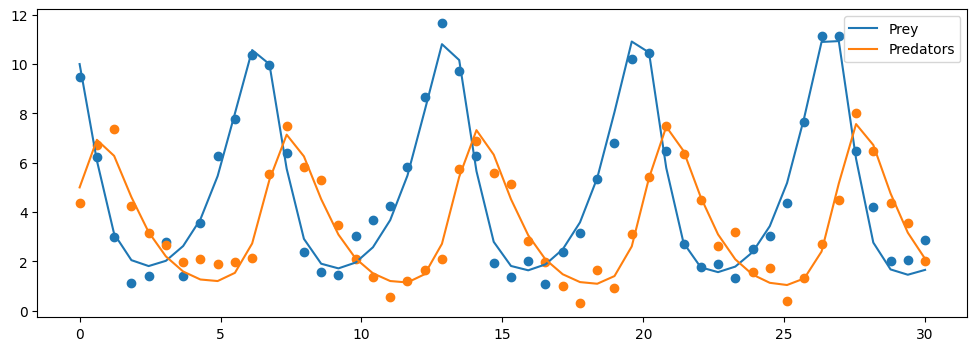

In [15]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics from the exact method

In [16]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc_)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.092,0.295,-0.376,0.633,0.017,0.013,627.0,297.0,1.01
"beta[0, 1]",0.896,0.161,0.583,1.149,0.009,0.006,547.0,349.0,1.01
"beta[0, 2]",0.020,0.103,-0.147,0.261,0.004,0.003,865.0,718.0,1.00
"beta[0, 3]",0.015,0.016,-0.009,0.047,0.001,0.001,601.0,487.0,1.01
"beta[0, 4]",-0.293,0.030,-0.348,-0.236,0.001,0.001,909.0,1008.0,1.00
"beta[0, 5]",-0.010,0.022,-0.056,0.026,0.001,0.001,762.0,761.0,1.00
"beta[1, 0]",-0.000,0.163,-0.317,0.358,0.006,0.005,1093.0,856.0,1.00
"beta[1, 1]",-0.015,0.065,-0.156,0.101,0.002,0.002,939.0,649.0,1.01
"beta[1, 2]",-0.923,0.119,-1.142,-0.688,0.004,0.003,1046.0,1384.0,1.00
"beta[1, 3]",0.008,0.010,-0.007,0.030,0.000,0.000,424.0,299.0,1.01


[]

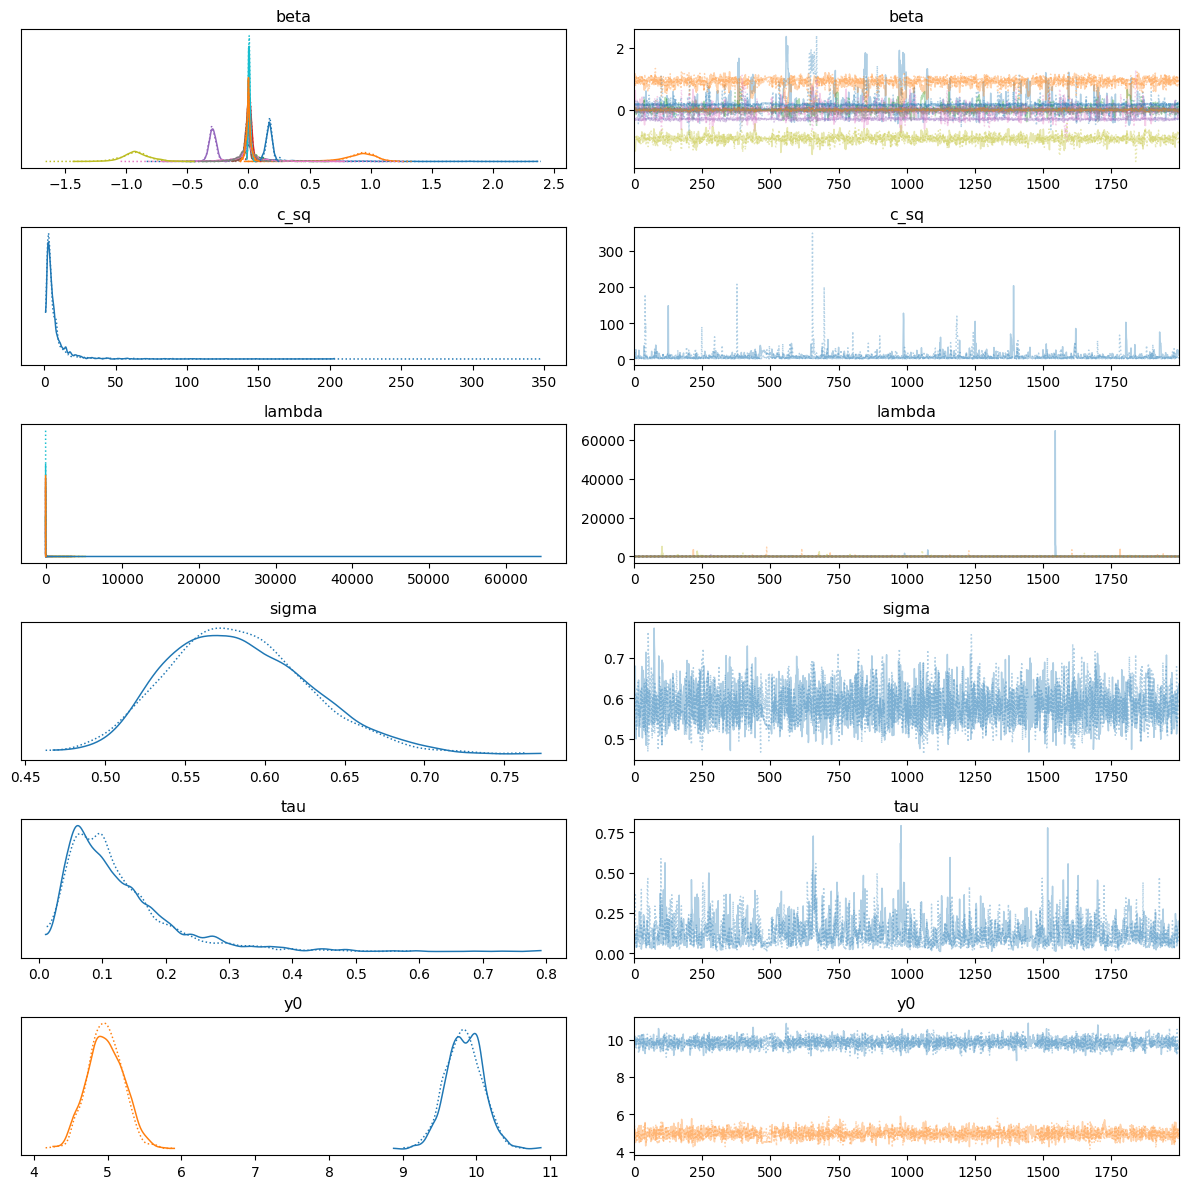

In [17]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()